# Genetic Column Generation



In [3]:
import numpy as np
import matplotlib.pyplot as plt

## Generate Problem

Let's start with simple gaussians

$$ f(x) = \frac{1}{\sigma \sqrt{2 \pi}} \exp \left\{ -\frac{1}{2} \left( \frac{x - \mu}{\sigma} \right)^{2} \right\} $$

In [17]:
def generate_gaussian_distribution(num_points, mean, std, range_min, range_max):
    grid = np.linspace(range_min, range_max, num_points)
    pdf_values = 1/(std * np.sqrt(2 * np.pi)) * np.exp(-1/2 * np.power( (grid - mean)/std, 2))
    pdf_values /= pdf_values.sum()
    return grid, pdf_values

In [ ]:
# BUT THIS ONE IS ONLY UASBLE FOR 2 MARGINAL PROBLEM!!!
def generate_gaussian_ot_problem(num_samples, mean1, std1, mean2, std2, range_min, range_max):
    grid1, pdf1 = generate_gaussian_distribution(num_samples, mean1, std1, range_min, range_max)
    grid2, pdf2 = generate_gaussian_distribution(num_samples, mean2, std2, range_min, range_max)

    cost = np.power(grid1[:, np.newaxis] - grid2, 2)

    return grid1, pdf1, grid2, pdf2, cost

Let's focus on $\Omega = [0, 1]$ space with that cost matrix as squared difference.

/run/user/1000/ipykernel_172774/1513119330.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


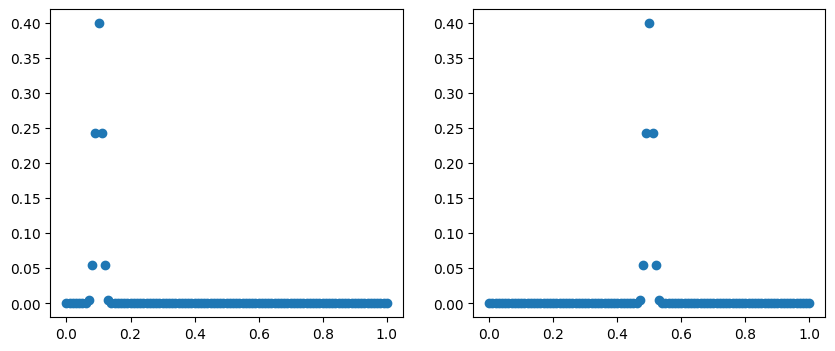

In [23]:
n = 100 + 1   # Number of points
std = 0.01
grid1, mu1, grid2, mu2, c = generate_gaussian_ot_problem(
    n,    # Number of samples
    0.1,  # Mean of first marginal
    std,  # STD of first marginal
    0.5,  # Mean of second marginal -- will be shifted
    std,  # STD of second marginal
    0, 1  # our Omega
)

fig, axs = plt.subplots(1, 2, figsize=(10,4))
axs[0].scatter(grid1, mu1)
axs[1].scatter(grid2, mu2)
fig.show()

/run/user/1000/ipykernel_172774/1684229598.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


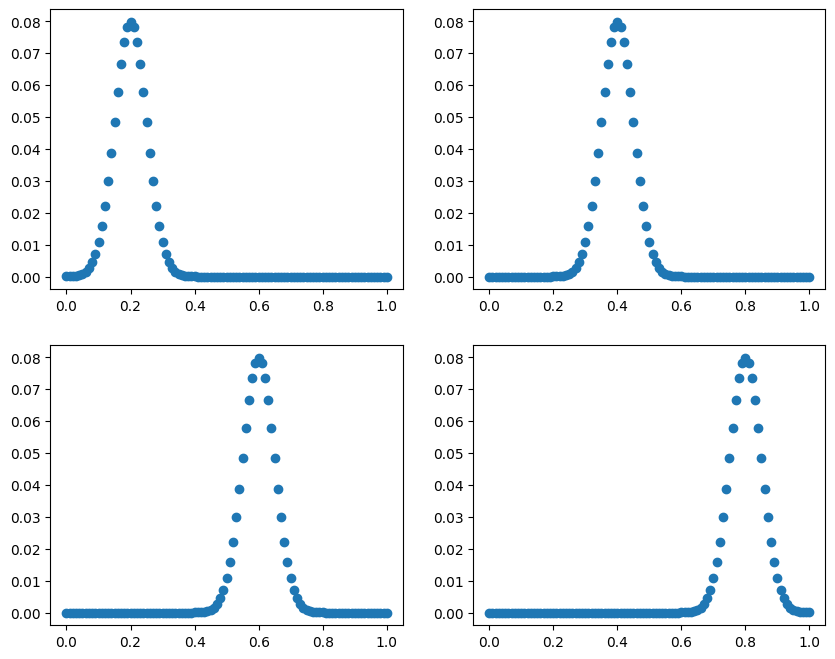

In [24]:
n = 100 + 1   # Number of points
std = 0.05
range_min = 0
range_max = 1

grid1, pdf1 = generate_gaussian_distribution(n, 0.2, std, range_min, range_max)
grid2, pdf2 = generate_gaussian_distribution(n, 0.4, std, range_min, range_max)
grid3, pdf3 = generate_gaussian_distribution(n, 0.6, std, range_min, range_max)
grid4, pdf4 = generate_gaussian_distribution(n, 0.8, std, range_min, range_max)

fig, axs = plt.subplots(2, 2, figsize=(10,8))
axs[0][0].scatter(grid1, pdf1)
axs[0][1].scatter(grid2, pdf2)
axs[1][0].scatter(grid3, pdf3)
axs[1][1].scatter(grid4, pdf4)
fig.show()

## `GenCol` Algorithm

In [ ]:
def initialize_A_and_c(N, l, cost):
    k = l  # should pick another number of indices
    AI = np.eye(l, k)
    cI = cost[:, np.random.choice(cost.shape[1], k)]
    return AI, cI

def solve_rmp(AI, cI):
    # TODO: another method that fits here
    alpha_I = np.linalg.solve(AI, cI)  # Simplified solver using direct method
    return alpha_I

def solve_dual(AI, cI):
    # TODO: another method that fits here
    y_star = np.linalg.solve(AI.T, cI)  # Simplified solver using direct method
    return y_star

def mutate_parent(parent, l):
    child = parent.copy()
    # Randomly change one element in the parent to simulate mutation
    change_index = np.random.randint(len(parent) - 1, size=1)[0]
    child[change_index] = np.random.rand()
    return child


def genetic_column_generation(
        N: int,
        l: int, 
        beta: float,
        cost: np.ndarray,
        grids: np.ndarray,
        marginals: np.ndarray,
        maxiter: int,
        maxsamples: int,
        ):
    A_I, c_I = initialize_A_and_c(N, l, cost)
    samples = 0
    iter = 0
    gain = -1
    
    while iter <= maxiter:
        # TODO: need to pass grids and marginals there??
        alpha_I = solve_rmp(AI, cI)
        y_star = solve_dual(AI, cI)
        
        while gain <= 0 and samples <= maxsamples:
            # Select a random active column of AI
            # TODO: better selection mechanism
            parent_index = np.random.choice(np.where(alpha_I > 0)[0])
            parent = AI[:, parent_index]
            child = mutate_parent(parent, l)
            # TODO: how to compute cost here?
            # c_child = compute_cost(child)
            c_child = child
            
            # Calculate gain from adding the child column
            gain = np.dot(child, y_star) - c_child
            
            samples += 1
            
        # Update AI and cI with the new child column if there's a positive gain
        if gain > 0:
            AI = np.hstack((AI, child[:, np.newaxis]))
            cI = np.append(cI, c_child)
            if AI.shape[1] > beta * l:
                # Clear the oldest inactive columns
                inactive_indices = np.where(alpha_I == 0)[0]
                AI = np.delete(AI, inactive_indices[:l], axis=1)
                cI = np.delete(cI, inactive_indices[:l])
        
        iter += 1
    
    # TODO: what should I return exactly?
    return AI, alpha_I
